# Netoyage des données

## Les  imports

In [29]:
# !pip install fastparquet
# !pip install pgeocode

In [30]:
## Modifier le WorkDirectory
# wdir = '/tmp/gas'
# os.chdir(wdir)

In [31]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pgeocode
nomi = pgeocode.Nominatim('fr')

In [32]:
print('current work dir is:', os.getcwd())

current work dir is: /home/houcine/workspace/school-eda-serviceStations


In [33]:
# limiter le nombre de lignes à afficher à 4
# au lieu de faire un head() + un tail() il suffira d'afficher la DataFrame
pd.options.display.max_rows = 4

## Typage des DataFrames

### chargement de **pdv**

In [4]:
pdv = pd.read_csv('pdv.csv', dtype={"annee":str,"cp":str})

### cleaning ***longitude*** and ***latitude***

In metropolitan France :
<br>
the **latitude**  is between 42 and 51
<br>
and **longitude** is between -5 and 10

#### First we need to scale **longitude** and **latitude** correctly

The vaste majority should be scaled by 100,000. but there are some values that are already scaled properly.
So, we will only scale values that aren't in the right range.

Due to possible swaping between longitude and latitude we should take into account the global minimum range and global maximum range in order to scale correctly.
This means that values of longitude and latitude should be between -5 and 51.

In [34]:
# scale by 100,000 if longi or lati aren't in correct range
pdv.latitude.loc[~(-5 < pdv.latitude) &  (pdv.latitude < 51)]    /= 100000
pdv.longitude.loc[~(-5 < pdv.longitude) &  (pdv.longitude < 51)] /= 100000

/home/houcine/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


We would like to drop incorrect longitude and latitude but first we can correct the ones that were inversed

In [35]:
# handling inversed values
sub_pdv = pdv.loc[
            (42 <= pdv.longitude)&\
            (pdv.longitude <= 51)&\
            (-5 <= pdv.latitude)&\
            (pdv.latitude <= 10)]

the idea behind this step is this :
<br>
we compare longitude and latitude of the postal code with longitude and latitude of the **pdv** file

In [36]:
# loop over all sub_pdv values by using their original index (the one in pdv dataframe)
for index in sub_pdv.index:
    cp        = sub_pdv.loc[index,["cp"]][0]
    latitude  = sub_pdv.loc[index,["latitude"]][0]
    longitude = sub_pdv.loc[index,["longitude"]][0]
    
    # geographical informations associated to this postal code (note that we are only using France postal codes)
    geo_info = nomi.query_postal_code(cp)
    
    # calculating the squared difference between the postal code longitude
    # and latitude and we will compare them the to longitude and latitude of the station
    lati_diff_squared = (latitude - geo_info.longitude)**2
    long_diff_squared = (longitude - geo_info.latitude)**2
    
    is_it_near = lati_diff_squared < 2 and\
                     long_diff_squared < 2
    
    if not is_it_near:
        print("index :",index)
        print("/t cp",cp, ":",longitude, latitude)
        
    # print(res['country code'], res.postal_code)

after manually verifying the **latitude** and **longitude** that we couldn't find with *"pgeocode"* library 
<br>
we conclude that all **longitudes** and **latitudes** that were in the correct range were swaped

### swap values

In [37]:
lat = sub_pdv.latitude.copy()
sub_pdv.loc[:,"latitude"] = sub_pdv.longitude
sub_pdv.loc[:,"longitude"] = lat
sub_pdv

,annee,id,latitude,longitude,cp,pop,ouverture_debut,ouverture_fin,ouverture_saufjour,adresse,ville


In [38]:
# update the originale DataFrame and verify it
pdv.update(sub_pdv)
pdv.loc[sub_pdv.index]

,annee,id,latitude,longitude,cp,pop,ouverture_debut,ouverture_fin,ouverture_saufjour,adresse,ville


Now, latitudes and longitudes that remain outside of the correcte range will be converted to **Nan**

In [39]:
d = pdv.loc[(42 > pdv.latitude)|\
        (pdv.latitude > 51)|\
        (-5 > pdv.longitude)|\
        (pdv.longitude > 10)]

In [40]:
d.latitude = np.nan
d.longitude = np.nan

/home/houcine/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [20]:
pdv.update(d)

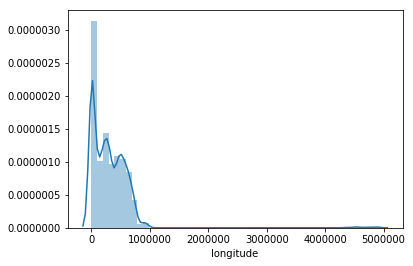

In [41]:
sns.distplot(pdv.dropna().longitude)

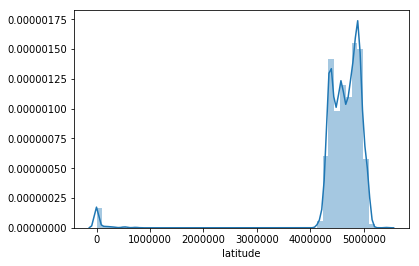

In [25]:
sns.distplot(pdv.dropna().latitude)

In [26]:
pdv.latitude.describe()

count    1.396480e+05
mean     4.608936e+06
             ...     
75%      4.876788e+06
max      6.260656e+06
Name: latitude, Length: 8, dtype: float64

In [27]:
pdv.loc[pdv.cp=="35***","cp"] = 35000

- **convertion des categories**

columns **'annee','pop','ouverture_saufjour'** it will be better to consider them as categories

In [45]:
pdv['annee']              = pdv['annee'].astype('category')
pdv['pop']                = pdv['pop'].astype('category')
pdv['ouverture_saufjour'] = pdv['ouverture_saufjour'].astype('category')


- **convertion des dates et temps**

In [48]:
mask = pdv['ouverture_debut'].str.len() == 5
pdv.loc[mask,'ouverture_debut'] = pdv.loc[mask,'ouverture_debut'] + ":00"

In [49]:
mask = pdv['ouverture_fin'].str.len() == 5
pdv.loc[mask,'ouverture_fin'] = pdv.loc[mask,'ouverture_fin'] + ":00"

In [50]:
pdv['ouverture_debut'] = pd.to_timedelta((pdv['ouverture_debut']))
pdv['ouverture_fin']   = pd.to_timedelta((pdv['ouverture_fin']))

In [52]:
pdv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140724 entries, 0 to 140723
Data columns (total 11 columns):
annee                 140724 non-null category
id                    140724 non-null float64
latitude              139648 non-null float64
longitude             139671 non-null float64
cp                    140724 non-null object
pop                   140724 non-null category
ouverture_debut       115226 non-null timedelta64[ns]
ouverture_fin         115226 non-null timedelta64[ns]
ouverture_saufjour    21623 non-null category
adresse               140724 non-null object
ville                 140724 non-null object
dtypes: category(3), float64(3), object(3), timedelta64[ns](2)
memory usage: 9.0+ MB


- **enregistrer la df compréssée**

In [36]:
pdv.to_parquet('pdv.gzip', 
               compression='gzip')

- **liberer la mémoire**

In [37]:
del pdv

### netoyage de **prix**

In [38]:
prix = pd.read_csv('prix.csv')

In [39]:
prix

,annee,id_pdv,nom,id,maj,valeur
0,2019,1000001,Gazole,1.0,2019-01-04T10:53:48,1328.0
1,2019,1000001,Gazole,1.0,2019-01-07T10:25:25,1348.0
2,2019,1000001,Gazole,1.0,2019-01-10T08:54:28,1374.0
3,2019,1000001,Gazole,1.0,2019-01-11T10:01:54,1387.0
4,2019,1000001,Gazole,1.0,2019-01-14T11:04:53,1394.0
...,...,...,...,...,...,...
28552949,2016,95870009,SP98,6.0,2016-12-28T00:12:00,1427.0
28552950,2016,95870009,SP98,6.0,2016-12-29T00:12:00,1427.0
28552951,2016,95870009,SP98,6.0,2016-12-30T00:12:00,1432.0
28552952,2016,95870009,SP98,6.0,2016-12-31T00:12:00,1439.0


In [40]:
prix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28552954 entries, 0 to 28552953
Data columns (total 6 columns):
annee     int64
id_pdv    int64
nom       object
id        float64
maj       object
valeur    float64
dtypes: float64(2), int64(2), object(2)
memory usage: 1.3+ GB


**la DataFrame prix est trés grande (1,3 GB).On peut diminuer sa taille en convertant des variables en Category.**

- **convertion des categories**

In [41]:
findLargeCols(prix)

col_name                            n               n_distinct     ratio
annee                            28552954                   13  2196381%
id_pdv                           28552954                16826     1697%
nom                              28552954                    7  4078993%
id                               28552954                    7  4078993%
maj                              28552954             11299903        3%
valeur                           28552954                 1944    14688%


les columns **'id_pdv','annee','nom','id'** mieux vaut les considérer des categories. on laisse **'valeur'** en **int**

In [42]:
prix["id_pdv"] = prix["id_pdv"].astype('category')
prix["annee"]  = prix["annee"].astype('category')
prix["nom"]    = prix["nom"].astype('category')
prix["id"]     = prix["id"].astype('category')

In [43]:
prix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28552954 entries, 0 to 28552953
Data columns (total 6 columns):
annee     category
id_pdv    category
nom       category
id        category
maj       object
valeur    float64
dtypes: category(4), float64(1), object(1)
memory usage: 572.6+ MB


**la taille de la df diminue de 1.3GB à 0.57GB**

- **convertion des dates et temps**

In [44]:
prix['maj'] = pd.to_datetime(prix['maj'])

In [45]:
prix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28552954 entries, 0 to 28552953
Data columns (total 6 columns):
annee     category
id_pdv    category
nom       category
id        category
maj       datetime64[ns]
valeur    float64
dtypes: category(4), datetime64[ns](1), float64(1)
memory usage: 572.6 MB


In [46]:
prix

,annee,id_pdv,nom,id,maj,valeur
0,2019,1000001,Gazole,1.0,2019-01-04 10:53:48,1328.0
1,2019,1000001,Gazole,1.0,2019-01-07 10:25:25,1348.0
2,2019,1000001,Gazole,1.0,2019-01-10 08:54:28,1374.0
3,2019,1000001,Gazole,1.0,2019-01-11 10:01:54,1387.0
4,2019,1000001,Gazole,1.0,2019-01-14 11:04:53,1394.0
...,...,...,...,...,...,...
28552949,2016,95870009,SP98,6.0,2016-12-28 00:12:00,1427.0
28552950,2016,95870009,SP98,6.0,2016-12-29 00:12:00,1427.0
28552951,2016,95870009,SP98,6.0,2016-12-30 00:12:00,1432.0
28552952,2016,95870009,SP98,6.0,2016-12-31 00:12:00,1439.0


- **enregistrer la df compréssée**

In [47]:
prix.to_parquet('prix.gzip',
               compression='gzip')

- **liberer la mémoire**

In [48]:
del prix

### netoyage de **services**

In [49]:
services = pd.read_csv('services.csv')

In [50]:
services

,annee,id_pdv,service
0,2019,1000001,Station de gonflage
1,2019,1000001,"Vente de gaz domestique (Butane, Propane)"
2,2019,1000001,DAB (Distributeur automatique de billets)
3,2019,1000002,"Vente de gaz domestique (Butane, Propane)"
4,2019,1000002,DAB (Distributeur automatique de billets)
...,...,...,...
837086,2016,95870009,Lavage multi-programmes
837087,2016,96600001,Carburant qualité supérieure
837088,2016,96600001,Boutique non alimentaire
837089,2016,96600001,Baie de service auto


In [51]:
services.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837091 entries, 0 to 837090
Data columns (total 3 columns):
annee      837091 non-null int64
id_pdv     837091 non-null int64
service    837091 non-null object
dtypes: int64(2), object(1)
memory usage: 19.2+ MB


- **convertion des categories**

In [52]:
findLargeCols(services)

col_name                            n               n_distinct     ratio
annee                              837091                   13    64392%
id_pdv                             837091                15179       55%
service                            837091                   36    23253%


les columns **'annee','id_pdv','service'** mieux vaut les considérer des categories.

In [53]:
services["annee"]   = services["annee"].astype('category')
services["id_pdv"]  = services["id_pdv"].astype('category')
services["service"] = services["service"].astype('category')

In [54]:
services.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837091 entries, 0 to 837090
Data columns (total 3 columns):
annee      837091 non-null category
id_pdv     837091 non-null category
service    837091 non-null category
dtypes: category(3)
memory usage: 3.9 MB


In [56]:
services

,annee,id_pdv,service
0,2019,1000001,Station de gonflage
1,2019,1000001,"Vente de gaz domestique (Butane, Propane)"
2,2019,1000001,DAB (Distributeur automatique de billets)
3,2019,1000002,"Vente de gaz domestique (Butane, Propane)"
4,2019,1000002,DAB (Distributeur automatique de billets)
...,...,...,...
837086,2016,95870009,Lavage multi-programmes
837087,2016,96600001,Carburant qualité supérieure
837088,2016,96600001,Boutique non alimentaire
837089,2016,96600001,Baie de service auto


- **enregistrer la df compréssée**

In [57]:
services.to_parquet('services.gzip',
               compression='gzip')

- **liberer la mémoire**

In [58]:
del services

In [13]:
mask = pdv['rupture_debut'].str[:4] == "0216"
pdv.loc[mask,'rupture_debut'] = "2016" + pdv[mask]['rupture_debut'].str[4:]

KeyError: 'rupture_debut'

In [77]:
mask = pdv['rupture_debut'].str[:4] == "0216"
pdv[mask]['rupture_debut']

Series([], Name: rupture_debut, dtype: object)

In [18]:
pdv['rupture_debut']   = pd.to_datetime(pdv['rupture_debut'])
pdv['rupture_fin']     = pd.to_datetime(pdv['rupture_fin'])
pdv['fermeture_debut'] = pd.to_datetime(pdv['fermeture_debut'])
pdv['fermeture_fin']   = pd.to_datetime(pdv['fermeture_fin'])

KeyError: 'rupture_debut'